In [139]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## PHYS 512 - Problem Set 1
Tristan Ménard<br>
260675783
### Problem 1
#### a) 

In [2]:
def fit_truncated_chebyshev(x, y, order1, tol=1e-6):
    
    # Rescale the x domain to -1 <= x <= +1
    xx = np.linspace(-1, 1, len(x))
    
    # Build the Chebyshev polynomial matrix A of order1
    A = np.zeros([len(x), order1+1])
    A[:,0] = 1.0
    if order1 > 0:
        A[:,1] = xx
        for i in range(2, order1+1):
            A[:,i] = 2*xx*A[:,i-1] - A[:,i-2]
    
    # Minimize chi-squared
    # Solve np.dot(A.tranpose(), np.dot(Ninv, A))*m = np.dot(A.transpose(), np.dot(A, y)) for m
    # m are the best fit coefficients for the order1 Chebyshev polynomial
    noise = np.finfo(float).eps # take the noise in each measurement to be the machine precision
    Ninv = np.eye(len(x))/noise**2
    lhs = np.dot(A.transpose(), np.dot(Ninv, A))
    rhs = np.dot(A.transpose(), np.dot(Ninv, y))
    m = np.dot(rhs, np.linalg.inv(lhs))
    
    # Look for coefficients that are larger than the tolerance (=1E-6 by default)
    # nterms is the number of terms to needed to get the accuracy below the tolerance
#     nterms = np.sum(np.abs(m) >= tol)
    
    # Truncate the fitted Chebyshev polynomial to order2
#     A_trunc = A[:,:nterms]
#     m_trunc = m[:nterms]
#     fit_trunc = np.dot(A_trunc, m_trunc)
    
    # Find the last coefficient that is larger than the tolerance
    tmp = [i for i in range(len(m)) if np.abs(m[i]) >= tol]
    nterms = np.max(tmp)+1
    A_trunc = A[:,:nterms]
    m_trunc = m[:nterms]
    fit_trunc = np.dot(A_trunc, m_trunc)
    
    return fit_trunc, nterms

Number of terms needed: 8
===== Truncated Chebyshev residuals =====
Max Error: 3.196979381225873e-07
RMS Error: 1.919021821977172e-07
===== Least squares polynomial residuals =====
Max Error: 8.005001208566398e-07
RMS Error: 1.6782509317176955e-07


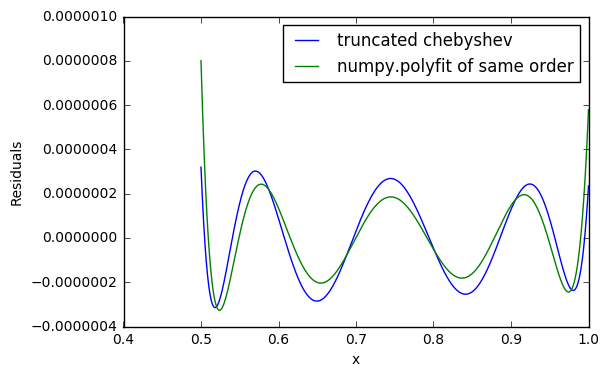

In [3]:
x = np.linspace(0.5,1,2000)
y = np.log2(x)

y_fit_trunc, nterms = fit_truncated_chebyshev(x, y, 15)
print('Number of terms needed: '+repr(nterms))
resid_trunc = y_fit_trunc-y
max_err_trunc = np.max(resid_trunc)
rms_err_trunc = np.sqrt(np.mean(resid_trunc**2))
print('===== Truncated Chebyshev residuals =====\nMax Error: '+repr(max_err_trunc)+'\nRMS Error: '+repr(rms_err_trunc))

p = np.polyfit(x, y, nterms-1)
y_fit_poly = np.polyval(p, x)
resid_poly = y_fit_poly-y
max_err_poly = np.max(resid_poly)
rms_err_poly = np.sqrt(np.mean(resid_poly**2))
print('===== Least squares polynomial residuals =====\nMax Error: '+repr(max_err_poly)+'\nRMS Error: '+repr(rms_err_poly))

plt.plot(x, resid_trunc, label='truncated chebyshev')
plt.plot(x, resid_poly, label='numpy.polyfit of same order')
plt.xlabel('x')
plt.ylabel('Residuals')
plt.legend()
plt.show()

#### b)

Number of terms needed: 55
Max Error: 4.317946089127389e-06


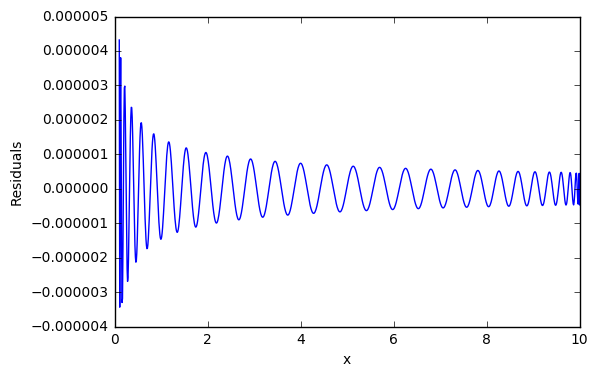

In [4]:
x = np.linspace(0.1,10,1000)
y = np.log2(x)

y_fit_trunc, nterms = fit_truncated_chebyshev(x, y, 100)
print('Number of terms needed: '+repr(nterms))
print('Max Error: '+repr((y_fit_trunc-y).max()))
plt.plot(x, y_fit_trunc-y)
plt.xlabel('x')
plt.ylabel('Residuals')
plt.show()

### Problem 2
#### a)

In [5]:
# Import the data
data = np.loadtxt('229614158_PDCSAP_SC6.txt', delimiter=',', skiprows=1)
time = data[:,0]
flux = data[:,1]

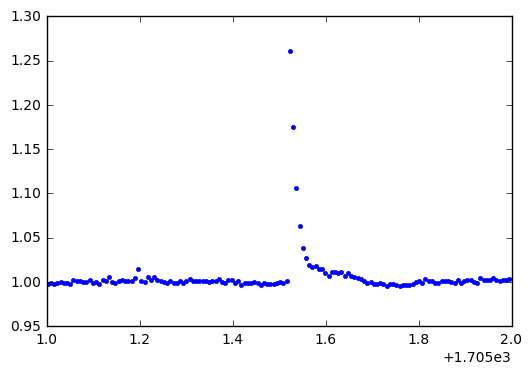

In [6]:
plt.plot(time, flux, '.')
plt.xlim(1706,1707)
plt.show()

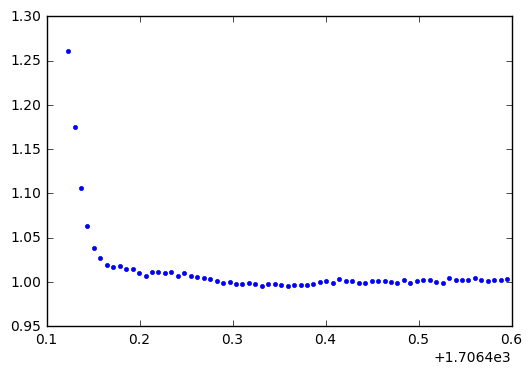

In [7]:
idx1 = np.argmax(flux)
idx2 = sum(time<1707)
new_time = time[idx1:idx2]
new_flux = flux[idx1:idx2]

plt.plot(new_time, new_flux, '.')
plt.show()

In [8]:
def model_derivs(pars, x):
    A = pars[0]
    B = pars[1]
    C = pars[2]
    D = pars[3]
    expvec = np.exp(-B*(x-C))
    fun = A*expvec + D
    dA = expvec
    dB = (C-x)*A*expvec
    dC = B*A*expvec
    dD = 1.0
    derivs = np.zeros([len(x), len(pars)])
    derivs[:,0] = dA
    derivs[:,1] = dB
    derivs[:,2] = dC
    derivs[:,3] = dD
    return fun, derivs

In [158]:
x = new_time
y = new_flux
n = 5
pars = np.asarray([1, 50, 1706.5, 1])
chi_old = 0

all_fun = np.zeros([len(x), n+1])
all_fun[:,0] = y

for i in range(1,n+1):
    fun, derivs = model_derivs(pars, x)
    all_fun[:,i] = fun
    resid = y-fun
    chi_new = np.sum(resid**2)
    grad = 2*np.dot(derivs.transpose(), resid)
    curve = 2*np.dot(derivs.transpose(), derivs)
    pars = pars + np.dot(np.linalg.inv(curve), grad)
    print('Change in chi-squared is '+repr(chi_new-chi_old))
    chi_old = chi_new

Change in chi-squared is 0.013606423995440601
Change in chi-squared is -0.011915209954368133
Change in chi-squared is -0.00039452660802722413
Change in chi-squared is -4.131774635263152e-06
Change in chi-squared is -7.067833494005943e-07


In [14]:
%matplotlib notebook

<IPython.core.display.Javascript object>


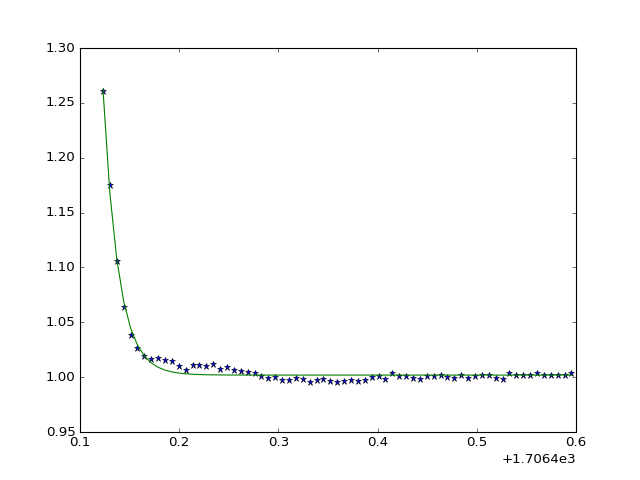

In [200]:
"""
A simple example of an animated plot
"""
fig, ax = plt.subplots()

plt.plot(new_time, new_flux, '*')
newline, = plt.plot([], [])

def animate(i):
    newline.set_data(new_time, all_fun[:,i])
    return newline,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(1,10), interval=1000, blit=True, repeat=False)

plt.show()

In [146]:
pars

array([2.46640803e+00, 6.48444725e+01, 1.70648849e+03, 1.00188642e+00])

In [151]:
pars

array([1.32205685e+00, 6.48442919e+01, 1.70649811e+03, 1.00188640e+00])

In [154]:
fun1, _ = model_derivs(pars, new_time)
chisq = np.sum((new_flux-fun1)**2)
chisq

0.0012917857026613238

<IPython.core.display.Javascript object>


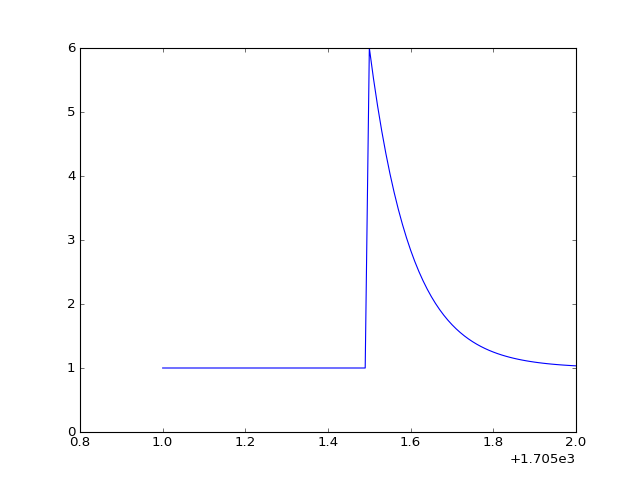

In [210]:
A = 5
B = 10
C = 1706.5
D = 1
x = np.linspace(1706,1707,101)
plt.plot(x, [D if i < C else A*np.exp(-B*(i-C))+D for i in x])
plt.ylim(0,)
plt.show()

In [180]:
len([0 if i < 0 else np.exp(-i) for i in x])

100